# Product Recommendations 
In this short project, we try to recommend products to users. We have sales transaction data for online retail downloaded from UIC repo. 

We try two approaches. In the first approach, we use simple counts to determine which items are bought together with other items. In another approach, we use wordvec model on sales transactions data and use items as words and baskets as sentences. This way we train item embeddings using wordvec model which model behavior of purchases into the model. Once we generate embeddings, we can find similar products for any given model using existing nearest neighbook lookup approaches. 

## Word2vec model
Word2Vec is one of the most common techniques for learning word embeddings. This technique is based on the assumption that words in the same contexts usually have similar meanings. Word embedding is a vector representation of a word and its input is the text corpus, and its output is a set of vectors, each corresponding to word in corpus. Word embeddings using word2vec can make natural language readable for the computer, and then one can apply further implementation of mathematical operations on words to detect their similarity. A well-trained set of word vectors will place similar words close together in this space.



In [1]:
import pandas as pd
import numpy as np
import random
from tqdm import tqdm
from gensim.models import Word2Vec 
import matplotlib.pyplot as plt
%matplotlib inline

import warnings;
warnings.filterwarnings('ignore')

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [43]:
#Loading Dataset 
df=pd.read_excel("/content/drive/MyDrive/Colab Notebooks/Online Retail.xlsx")

In [3]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [44]:
#droping the duplicates
df=df.drop_duplicates()

In [45]:
#droping the rows with NULL values
df.dropna(inplace=True)

In [46]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 401604 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    401604 non-null  object        
 1   StockCode    401604 non-null  object        
 2   Description  401604 non-null  object        
 3   Quantity     401604 non-null  int64         
 4   InvoiceDate  401604 non-null  datetime64[ns]
 5   UnitPrice    401604 non-null  float64       
 6   CustomerID   401604 non-null  float64       
 7   Country      401604 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 27.6+ MB


In [47]:
# converting StokCode to str and CustomerId to int from float
df['StockCode']=df['StockCode'].astype(str)
df['CustomerID']=df['CustomerID'].astype(int)

In [9]:
# Shuffle dataframe using sample function
df = df.sample(frac=1)

# extract 90% of customer ID's
ratio = 0.9

total_rows = df.shape[0]
train_size = int(total_rows*ratio)

# Split data into test and train, train has 90% data 10% is for testing our model
train = df[0:train_size]
test = df[train_size:]


In [49]:
# finding items bough together and their frequency of geeting bought together
df1 = train[['InvoiceNo','StockCode']]
df3 = df1
df3 = df3.rename(columns={"StockCode": "StockCode1", "InvoiceNo": "InvoiceNo"})
df4 = pd.merge(df1,df3,on="InvoiceNo").groupby(['StockCode','StockCode1'], as_index=False).count().rename(columns={'InvoiceNo':'Frequency'}).reset_index(drop=True)

In [50]:
df4.head(5)

,StockCode,StockCode1,Frequency
0,10002,10002,43
1,10002,10120,2
2,10002,10123C,1
3,10002,10125,2
4,10002,10133,1


In [51]:
# removing same items as there is no sense of same item getting purchesed together
df4=df4[df4['StockCode']!=df4['StockCode1']]

In [52]:
df4=df4.sort_values(['StockCode', 'Frequency'], ascending=[True, False]).reset_index()
df4

,index,StockCode,StockCode1,Frequency
0,48,10002,20725,10
1,394,10002,22383,10
2,50,10002,20727,9
3,479,10002,22558,7
4,793,10002,84879,7
...,...,...,...,...
4211821,4215486,POST,90192,1
4211822,4215487,POST,90201A,1
4211823,4215490,POST,90201D,1
4211824,4215491,POST,90202D,1


In [53]:
#droping extra index column
df4.drop(['index'], axis=1, inplace=True)

In [54]:
#for each item top five items for each item based on frequency count
df5=df4.groupby('StockCode').head(5).reset_index(drop=True)
df5=df5[['StockCode',	'StockCode1']]
df5

,StockCode,StockCode1
0,10002,20725
1,10002,22383
2,10002,20727
3,10002,22558
4,10002,84879
...,...,...
18257,POST,22326
18258,POST,22423
18259,POST,22328
18260,POST,22554


In [55]:
# trained model which contains top 5 purchesed items for each item
df5=df5.groupby(['StockCode']).agg({'StockCode1': list}).reset_index()

In [56]:
# Creating a dictionary conating item code as key and its description as value
products = df[["StockCode", "Description"]]

# remove duplicates
products.drop_duplicates(inplace=True, subset='StockCode', keep="last")

# create product-ID and product-description dictionary
products_dict= products.groupby('StockCode')['Description'].apply(list).to_dict()

In [57]:
# test the dictionary
products_dict['M']

['Manual']

In [58]:
df5['StockCode11']=df5['StockCode1'].apply(lambda x: [products_dict[i] for i in x])
df5

,StockCode,StockCode1,StockCode11
0,10002,"[20725, 22383, 20727, 22558, 84879]","[[LUNCH BAG RED RETROSPOT], [LUNCH BAG SUKI DE..."
1,10080,"[21591, 22197, 22086, 22952, 23076]","[[COSY HOUR CIGAR BOX MATCHES ], [POPCORN HOLD..."
2,10120,"[16237, 16236, 16238, 21034, 20992]","[[SLEEPING CAT ERASERS], [KITTY PENCIL ERASERS..."
3,10123C,"[22147, 22382, 22384, 22614, 22804]","[[FELTCRAFT BUTTERFLY HEARTS], [LUNCH BAG SPAC..."
4,10124A,"[22161, 10124G, 21018, 21034, 21811]","[[HEART DECORATION RUSTIC HANGING ], [ARMY CAM..."
...,...,...,...
3654,D,[M],[[Manual]]
3655,DOT,"[23263, 22446, 23264, 22107, 23265]","[[SET OF 3 WOODEN HEART DECORATIONS], [PIN CUS..."
3656,M,"[85123A, 21034, 22423, 84879, 22197]","[[CREAM HANGING HEART T-LIGHT HOLDER], [REX CA..."
3657,PADS,"[21524, 23300, 23395, 46000M, 46000S]","[[DOORMAT SPOTTY HOME SWEET HOME], [GARDENERS ..."


In [59]:
# Working on testing dataset 
test.reset_index(drop=True, inplace=True)

In [60]:
test.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536366,22633,HAND WARMER UNION JACK,6,2010-12-01 08:28:00,1.85,17850,United Kingdom
1,536366,22632,HAND WARMER RED POLKA DOT,6,2010-12-01 08:28:00,1.85,17850,United Kingdom
2,536368,22960,JAM MAKING SET WITH JARS,6,2010-12-01 08:34:00,4.25,13047,United Kingdom
3,536368,22913,RED COAT RACK PARIS FASHION,3,2010-12-01 08:34:00,4.95,13047,United Kingdom
4,536368,22912,YELLOW COAT RACK PARIS FASHION,3,2010-12-01 08:34:00,4.95,13047,United Kingdom


In [61]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41298 entries, 0 to 41297
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   InvoiceNo    41298 non-null  object        
 1   StockCode    41298 non-null  object        
 2   Description  41298 non-null  object        
 3   Quantity     41298 non-null  int64         
 4   InvoiceDate  41298 non-null  datetime64[ns]
 5   UnitPrice    41298 non-null  float64       
 6   CustomerID   41298 non-null  int64         
 7   Country      41298 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(2), object(4)
memory usage: 2.5+ MB


In [62]:
test_gr=test.groupby('InvoiceNo').filter(lambda x: x['StockCode'].count()>1)
#test_gr['InvoiceNo']=test['InvoiceNo'].unique()
df_test=test_gr.groupby('InvoiceNo').agg({'StockCode':list}).reset_index(drop=True)

In [63]:
test_gr.InvoiceNo.nunique()

1900

In [64]:
# Items bought in each transcation
df_test

,StockCode
0,"[22633, 22632]"
1,"[22960, 22913, 22912, 22914]"
2,"[85123A, 71053, 84406B, 15056BL, 20679, 37370,..."
3,"[22110, 22098, 22100, 22766, 22451, 22549, 847..."
4,"[20728, 22382, 22326, 22662, 22383, 20727, 223..."
...,...
1895,"[M, M, 70007, 85175, 84821, 84819, 84817, 7258..."
1896,"[23201, 23080]"
1897,"[85099B, 84828, 79191C, 23392, 23344, 23209, 2..."
1898,"[22627, 82484]"


In [65]:
df_test['StockCode11']=df_test['StockCode'].apply(lambda x: [products_dict[i] for i in x])
df_test.head()

,StockCode,StockCode11
0,"[22633, 22632]","[[HAND WARMER UNION JACK], [HAND WARMER RED RE..."
1,"[22960, 22913, 22912, 22914]","[[JAM MAKING SET WITH JARS], [RED COAT RACK PA..."
2,"[85123A, 71053, 84406B, 15056BL, 20679, 37370,...","[[CREAM HANGING HEART T-LIGHT HOLDER], [WHITE ..."
3,"[22110, 22098, 22100, 22766, 22451, 22549, 847...","[[BIRD HOUSE HOT WATER BOTTLE], [BOUDOIR SQUAR..."
4,"[20728, 22382, 22326, 22662, 22383, 20727, 223...","[[LUNCH BAG CARS BLUE], [LUNCH BAG SPACEBOY DE..."


In [66]:
df_test['seed']=df_test['StockCode'].apply(lambda x: x[0])
df_test

,StockCode,StockCode11,seed
0,"[22633, 22632]","[[HAND WARMER UNION JACK], [HAND WARMER RED RE...",22633
1,"[22960, 22913, 22912, 22914]","[[JAM MAKING SET WITH JARS], [RED COAT RACK PA...",22960
2,"[85123A, 71053, 84406B, 15056BL, 20679, 37370,...","[[CREAM HANGING HEART T-LIGHT HOLDER], [WHITE ...",85123A
3,"[22110, 22098, 22100, 22766, 22451, 22549, 847...","[[BIRD HOUSE HOT WATER BOTTLE], [BOUDOIR SQUAR...",22110
4,"[20728, 22382, 22326, 22662, 22383, 20727, 223...","[[LUNCH BAG CARS BLUE], [LUNCH BAG SPACEBOY DE...",20728
...,...,...,...
1895,"[M, M, 70007, 85175, 84821, 84819, 84817, 7258...","[[Manual], [Manual], [HI TEC ALPINE HAND WARME...",M
1896,"[23201, 23080]","[[JUMBO BAG ALPHABET], [RED METAL BOX TOP SECR...",23201
1897,"[85099B, 84828, 79191C, 23392, 23344, 23209, 2...","[[JUMBO BAG RED RETROSPOT], [JUNGLE POPSICLES ...",85099B
1898,"[22627, 82484]","[[MINT KITCHEN SCALES], [WOOD BLACK BOARD ANT ...",22627


In [67]:
df_test['seed']=df_test['StockCode'].apply(lambda x: x.pop(0))

In [68]:
#seen is the first item of each transcation and StockCode is remaining items actually bough with the seed item
df_test.head()

,StockCode,StockCode11,seed
0,[22632],"[[HAND WARMER UNION JACK], [HAND WARMER RED RE...",22633
1,"[22913, 22912, 22914]","[[JAM MAKING SET WITH JARS], [RED COAT RACK PA...",22960
2,"[71053, 84406B, 15056BL, 20679, 37370, 21871, ...","[[CREAM HANGING HEART T-LIGHT HOLDER], [WHITE ...",85123A
3,"[22098, 22100, 22766, 22451, 22549, 84744, 850...","[[BIRD HOUSE HOT WATER BOTTLE], [BOUDOIR SQUAR...",22110
4,"[22382, 22326, 22662, 22383, 20727, 22328, 223...","[[LUNCH BAG CARS BLUE], [LUNCH BAG SPACEBOY DE...",20728


In [70]:
#trained data
df5.rename(columns={'StockCode':'seed'}, inplace=True)

In [71]:
# merging trained data and test data on seed (item)
df_merge=pd.merge(df_test,df5, on='seed', how='inner')


In [147]:
df_merge.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1895 entries, 0 to 1894
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   StockCode      1895 non-null   object
 1   StockCode11_x  1895 non-null   object
 2   seed           1895 non-null   object
 3   StockCode1     1895 non-null   object
 4   StockCode11_y  1895 non-null   object
dtypes: object(5)
memory usage: 88.8+ KB


In [72]:
df_comp=df_merge[['seed','StockCode','StockCode1']]
df_comp.head()

,seed,StockCode,StockCode1
0,22633,[22632],"[22865, 22866, 23439, 22632, 22867]"
1,22633,"[22867, 84029E, 85038, 22837, 22866, 21479, 21...","[22865, 22866, 23439, 22632, 22867]"
2,22960,"[22913, 22912, 22914]","[22961, 22720, 22666, 22993, 22423]"
3,22960,"[22969, 22961, 22966, 22926, 20725, 21982, 226...","[22961, 22720, 22666, 22993, 22423]"
4,22960,"[22971, 21915]","[22961, 22720, 22666, 22993, 22423]"


In [73]:
def intersec(lst1, lst3):
    return list(set(lst1) & set(lst3))

In [74]:
df_comp['intersect']=df_comp[['StockCode', 'StockCode1']].apply(lambda x: intersec(x.StockCode, x.StockCode1), axis=1)

In [75]:
df_comp

,seed,StockCode,StockCode1,intersect
0,22633,[22632],"[22865, 22866, 23439, 22632, 22867]",[22632]
1,22633,"[22867, 84029E, 85038, 22837, 22866, 21479, 21...","[22865, 22866, 23439, 22632, 22867]","[22867, 22866, 22632]"
2,22960,"[22913, 22912, 22914]","[22961, 22720, 22666, 22993, 22423]",[]
3,22960,"[22969, 22961, 22966, 22926, 20725, 21982, 226...","[22961, 22720, 22666, 22993, 22423]",[22961]
4,22960,"[22971, 21915]","[22961, 22720, 22666, 22993, 22423]",[]
...,...,...,...,...
1890,23567,[22178],"[23084, 23568, 23275, 21239, 22983]",[]
1891,22990,"[22666, 22452]","[22989, 22720, 22907, 22960, 22993]",[]
1892,21068,"[21871, 22064]","[21871, 85123A, 21071, 21877, 82482]",[21871]
1893,22800,"[22798, 84946]","[22798, 22801, 22423, 21314, 84879]",[22798]


In [76]:
hit_rate=sum(map(len, df_comp.intersect))/sum(map(len, df_comp.StockCode))*100
print("Hit_rate is:", hit_rate)

Hit_rate is: 4.418897072031615


##Using Word2Vec approach to find frequently bough items for each item

In [77]:
# list to capture purchase history of the customers
purchases_train = []

# populate the list with the product codes
for i in tqdm(customers_train):
    temp = train[train["InvoiceNo"] == i]["StockCode"].tolist()
    purchases_train.append(temp)

100%|██████████| 19971/19971 [10:38<00:00, 31.28it/s]


In [78]:
# list to capture purchase history of the customers
purchases_val = []

# populate the list with the product codes
for i in tqdm(test['InvoiceNo'].unique()):
    temp =test[test["InvoiceNo"] == i]["StockCode"].tolist()
    purchases_val.append(temp)

100%|██████████| 2219/2219 [00:08<00:00, 252.01it/s]


In [136]:
# train word2vec model
model = Word2Vec(window = 10, sg = 1, hs = 0,
                 negative = 1, # for negative sampling
                 alpha=0.03, min_alpha=0.0007,seed=14)

model.build_vocab(purchases_train, progress_per=200)

model.train(purchases_train, total_examples = model.corpus_count, 
            epochs=30, report_delay=1)

(10697614, 10809180)

In [137]:
model.init_sims(replace=True)
print(model)

Word2Vec(vocab=3168, size=100, alpha=0.03)


In [138]:
# extract all vectors
X = model[model.wv.vocab]

X.shape

(3168, 100)

In [ ]:
!pip uninstall umap
!pip install umap-learn

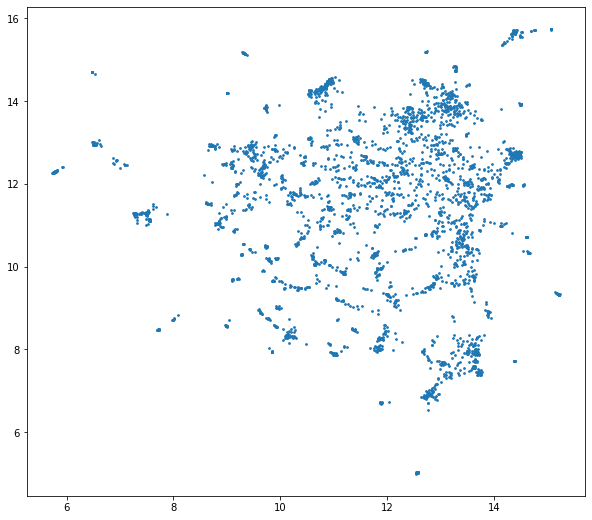

In [83]:
import umap.umap_ as umap


cluster_embedding = umap.UMAP(n_neighbors=30, min_dist=0.0,
                              n_components=2, random_state=42).fit_transform(X)

plt.figure(figsize=(10,9))
plt.scatter(cluster_embedding[:, 0], cluster_embedding[:, 1], s=3, cmap='Spectral')

In [139]:
products = train[["StockCode", "Description"]]

# remove duplicates
products.drop_duplicates(inplace=True, subset='StockCode', keep="last")

# create product-ID and product-description dictionary
products_dict= products.groupby('StockCode')['Description'].apply(list).to_dict()

In [140]:
# test the dictionary
products_dict['84029E']

['RED WOOLLY HOTTIE WHITE HEART.']

In [141]:
def similar_products(v, n = 5):
    
    # extract most similar products for the input vector
    ms = model.similar_by_vector(v, topn= n+1)[1:]
    new_ms=[]#print(ms)
    # extract name and similarity score of the similar products
    for i in ms:
      new_ms.append(i[0])

    """
    for j in ms:
        pair = (products_dict[j[0]][0], j[1])
        new_ms.append(pair)
        """
        
    return new_ms      

In [142]:
p=list(model.wv.vocab.keys())
vl=test.groupby('InvoiceNo').filter(lambda x: x['StockCode'].count()>1)

vl=vl.groupby('InvoiceNo').agg({'StockCode':list}).reset_index(drop=True)

In [143]:
vl['seed']=vl['StockCode'].apply(lambda x: x[0])
vl['seed']=vl['StockCode'].apply(lambda x: x.pop(0))

In [144]:
vl['recom1']=vl['seed'].apply(lambda x: similar_products(model[x]) if x in p else 0)
vl.head()

,StockCode,seed,recom1
0,[22632],22633,"[22866, 22632, 23439, 22865, 22867]"
1,"[22913, 22912, 22914]",22960,"[22961, 22722, 22720, 22963, 22962]"
2,"[71053, 84406B, 15056BL, 20679, 37370, 21871, ...",85123A,"[22804, 21733, 84836, 82482, 22469]"
3,"[22098, 22100, 22766, 22451, 22549, 84744, 850...",22110,"[21484, 22111, 21485, 21479, 23356]"
4,"[22382, 22326, 22662, 22383, 20727, 22328, 223...",20728,"[20726, 22384, 20725, 20727, 22383]"


In [145]:
vl=vl[vl['recom1']!=0]
vl['intersect']=vl[['StockCode', 'recom1']].apply(lambda x: intersec(x.StockCode, x.recom1), axis=1)
vl.head()

,StockCode,seed,recom1,intersect
0,[22632],22633,"[22866, 22632, 23439, 22865, 22867]",[22632]
1,"[22913, 22912, 22914]",22960,"[22961, 22722, 22720, 22963, 22962]",[]
2,"[71053, 84406B, 15056BL, 20679, 37370, 21871, ...",85123A,"[22804, 21733, 84836, 82482, 22469]",[82482]
3,"[22098, 22100, 22766, 22451, 22549, 84744, 850...",22110,"[21484, 22111, 21485, 21479, 23356]",[]
4,"[22382, 22326, 22662, 22383, 20727, 22328, 223...",20728,"[20726, 22384, 20725, 20727, 22383]","[22383, 20727, 20725]"


In [146]:
hit_rate=sum(map(len, vl.intersect))/sum(map(len, vl.StockCode))*100
print("Hit_rate is:", hit_rate)

Hit_rate is: 3.7590113285272917
